In [48]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

In [49]:
df = pd.read_csv("credit_card.csv")
print(df.dtypes)
df.describe()
# df.head()

actionnr                            int64
merchant_id                         int64
average_amount_transaction_day    float64
transaction_amount                float64
is_declined                           str
total_number_of_declines_day        int64
isforeigntransaction                  str
ishighriskcountry                     str
daily_chargeback_avg_amt            int64
sixmonth_avg_chbk_amt             float64
sixmonth_chbk_freq                  int64
isfradulent                           str
dtype: object


,actionnr,merchant_id,average_amount_transaction_day,transaction_amount,total_number_of_declines_day,daily_chargeback_avg_amt,sixmonth_avg_chbk_amt,sixmonth_chbk_freq
count,3075.000000,3.075000e+03,3074.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000
mean,1538.000000,5.026634e+09,514.931584,9876.399210,0.957398,55.737561,40.022407,0.391870
std,887.820365,9.870778e+08,291.906950,10135.331016,2.192391,206.634779,155.968840,1.548479
min,1.000000,3.160041e+09,4.011527,0.000000,0.000000,0.000000,0.000000,0.000000
25%,769.500000,4.170814e+09,269.778673,2408.781147,0.000000,0.000000,0.000000,0.000000
50%,1538.000000,5.025578e+09,502.522343,6698.891856,0.000000,0.000000,0.000000,0.000000
75%,2306.500000,5.889625e+09,765.121276,14422.568935,0.000000,0.000000,0.000000,0.000000
max,3075.000000,6.665906e+09,2000.000000,108000.000000,20.000000,998.000000,998.000000,9.000000


In [50]:
print(df.isnull().sum())

actionnr                          0
merchant_id                       0
average_amount_transaction_day    1
transaction_amount                0
is_declined                       0
total_number_of_declines_day      0
isforeigntransaction              0
ishighriskcountry                 0
daily_chargeback_avg_amt          0
sixmonth_avg_chbk_amt             0
sixmonth_chbk_freq                0
isfradulent                       0
dtype: int64


In [51]:
frd_count = df['isfradulent'].value_counts()
frd_prc = df['isfradulent'].value_counts(normalize=True) * 100

print(f"\n Distribution:")
print(f"  (N): {frd_count.get('N', 0)} ({frd_prc.get('N', 0):.2f}%)")
print(f"   - (Y): {frd_count.get('Y', 0)} ({frd_prc.get('Y', 0):.2f}%)")


 Distribution:
  (N): 2627 (85.43%)
   - (Y): 448 (14.57%)


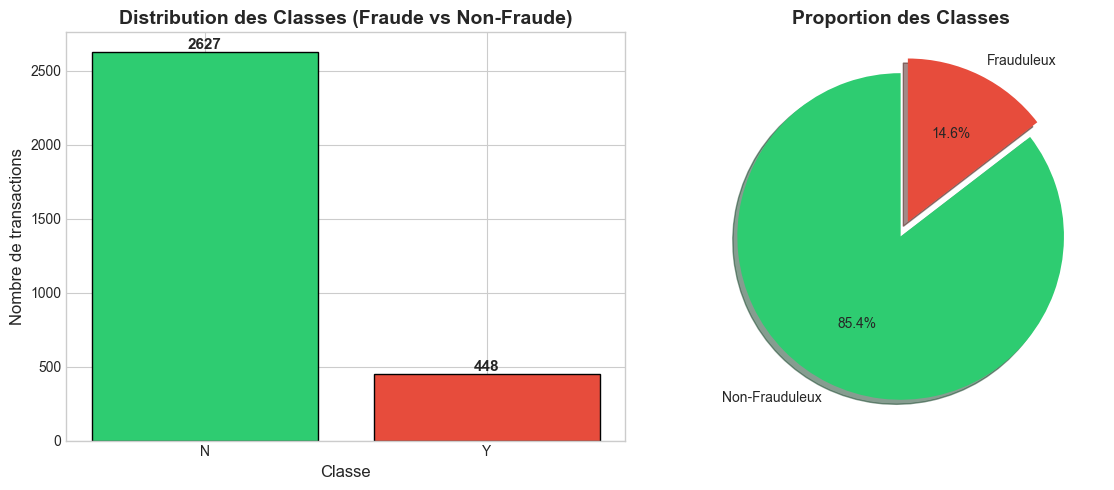

In [52]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#2ecc71', '#e74c3c']
ax1 = axes[0]
bars = ax1.bar(frd_count.index, frd_count.values, color=colors, edgecolor='black')
ax1.set_xlabel('Classe', fontsize=12)
ax1.set_ylabel('Nombre de transactions', fontsize=12)
ax1.set_title('Distribution des Classes (Fraude vs Non-Fraude)', fontsize=14, fontweight='bold')
for bar, count in zip(bars, frd_count.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             str(count), ha='center', fontsize=11, fontweight='bold')

ax2 = axes[1]
ax2.pie(frd_count.values, labels=['Non-Frauduleux', 'Frauduleux'], 
        autopct='%1.1f%%', colors=colors, explode=(0, 0.1),
        shadow=True, startangle=90)
ax2.set_title('Proportion des Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


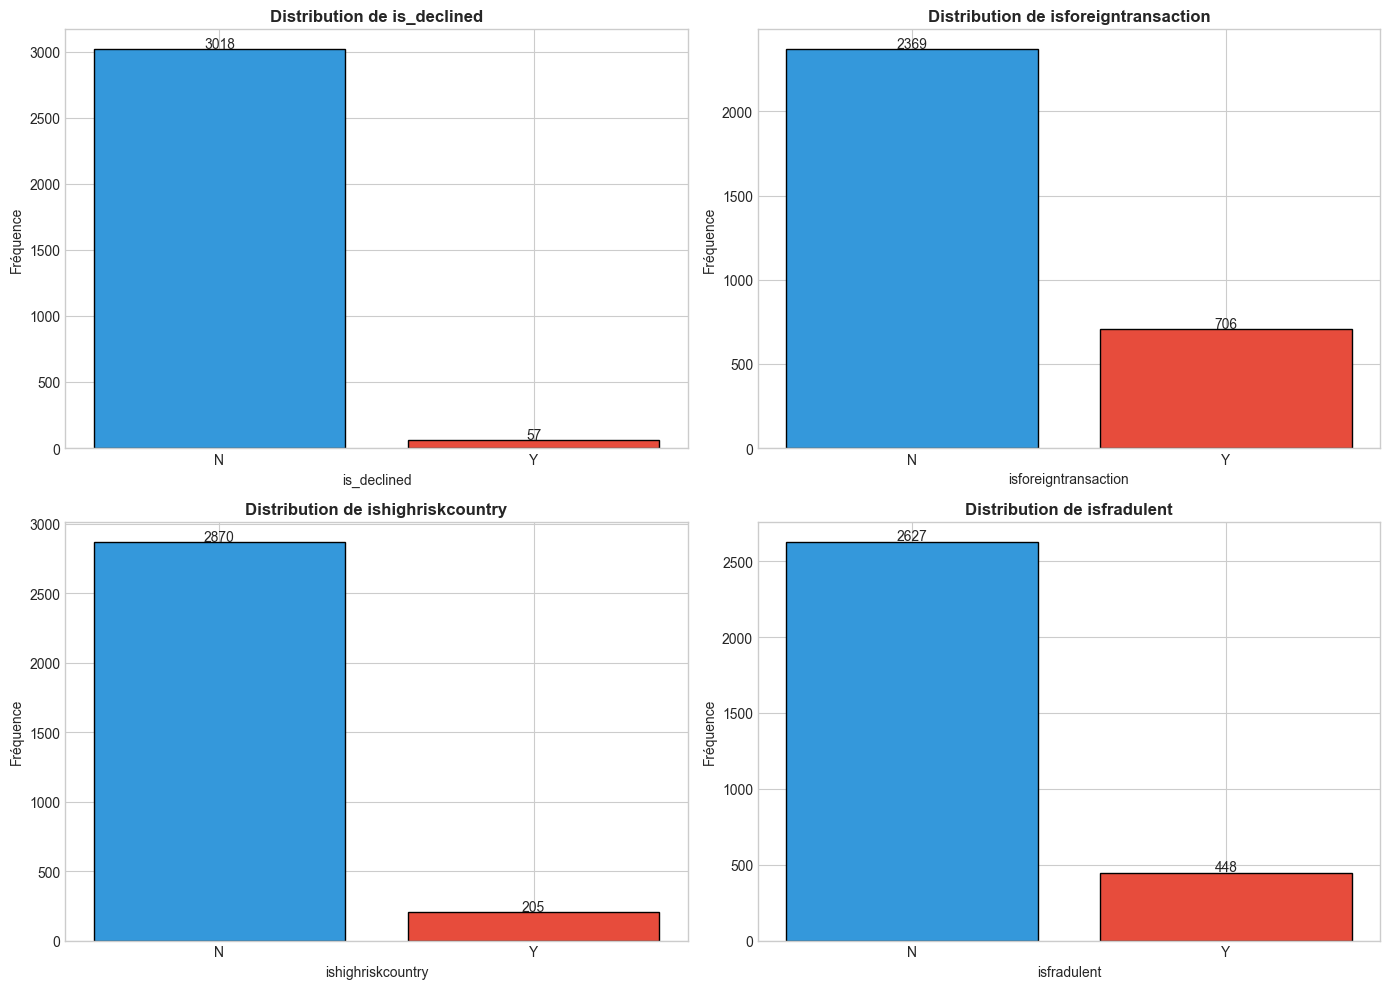

In [53]:
categorical_cols = ['is_declined', 'isforeigntransaction', 'ishighriskcountry', 'isfradulent']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    if col in df.columns:
        counts = df[col].value_counts()
        bars = ax.bar(counts.index, counts.values, color=['#3498db', '#e74c3c'], edgecolor='black')
        ax.set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Fréquence')
        
        for bar, count in zip(bars, counts.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                   str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

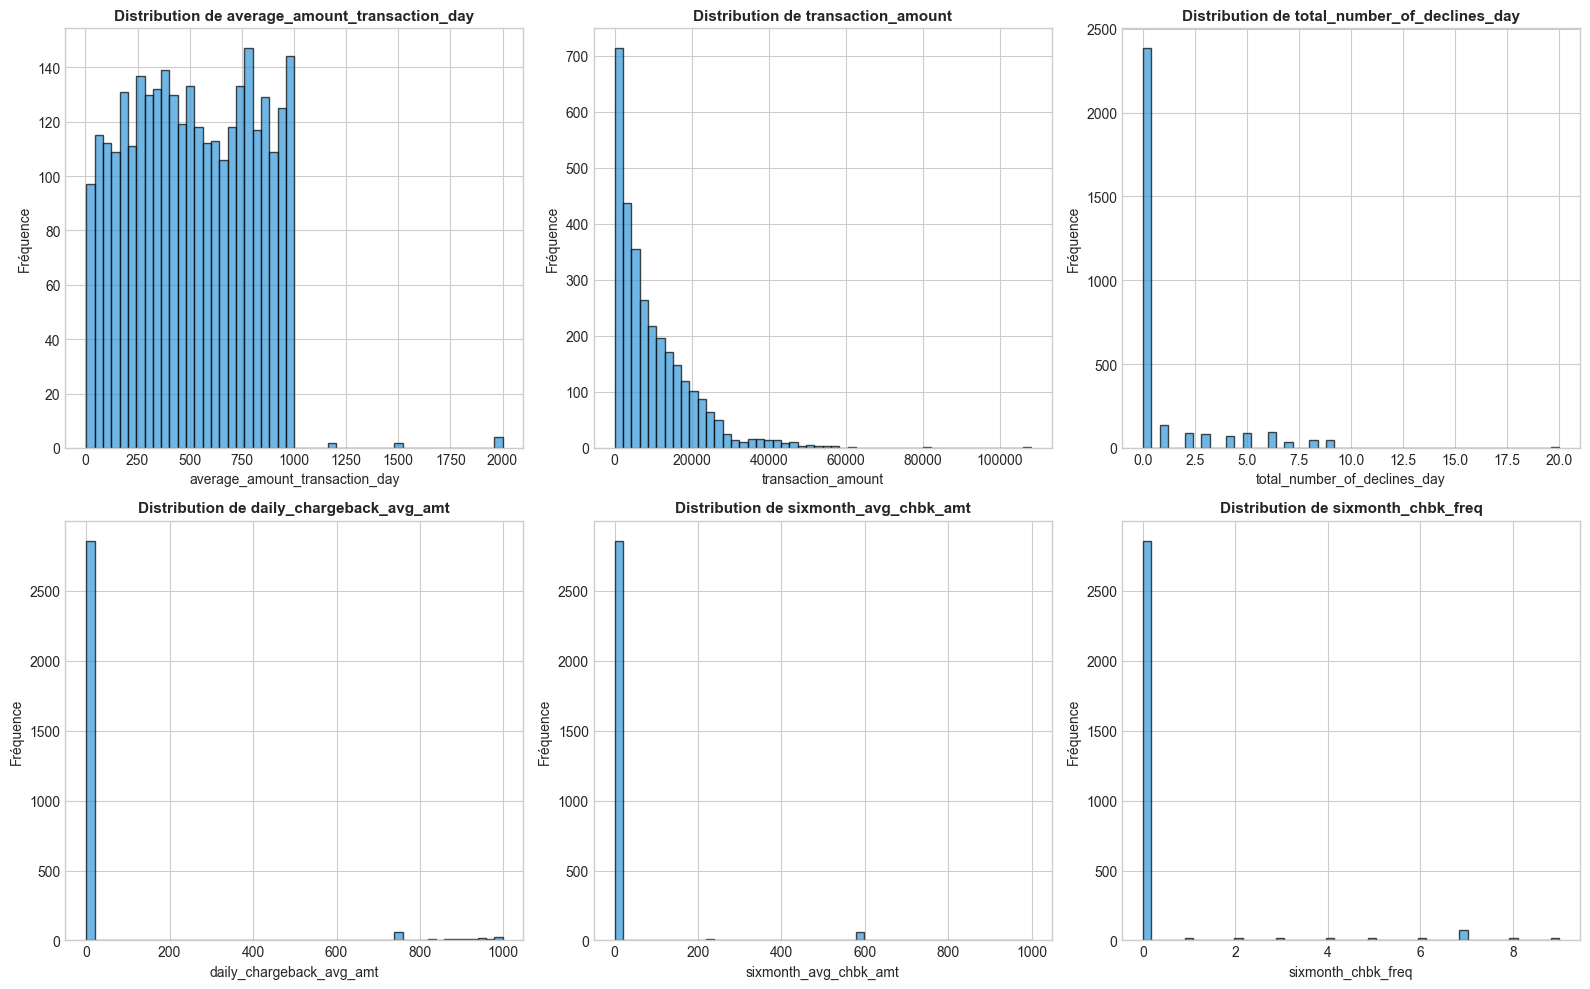

In [54]:
numeric_cols = ['average_amount_transaction_day', 'transaction_amount', 
                'total_number_of_declines_day', 'daily_chargeback_avg_amt',
                'sixmonth_avg_chbk_amt', 'sixmonth_chbk_freq']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    if col in df.columns:
        # Histogramme avec KDE
        df[col].hist(ax=ax, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution de {col}', fontsize=11, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

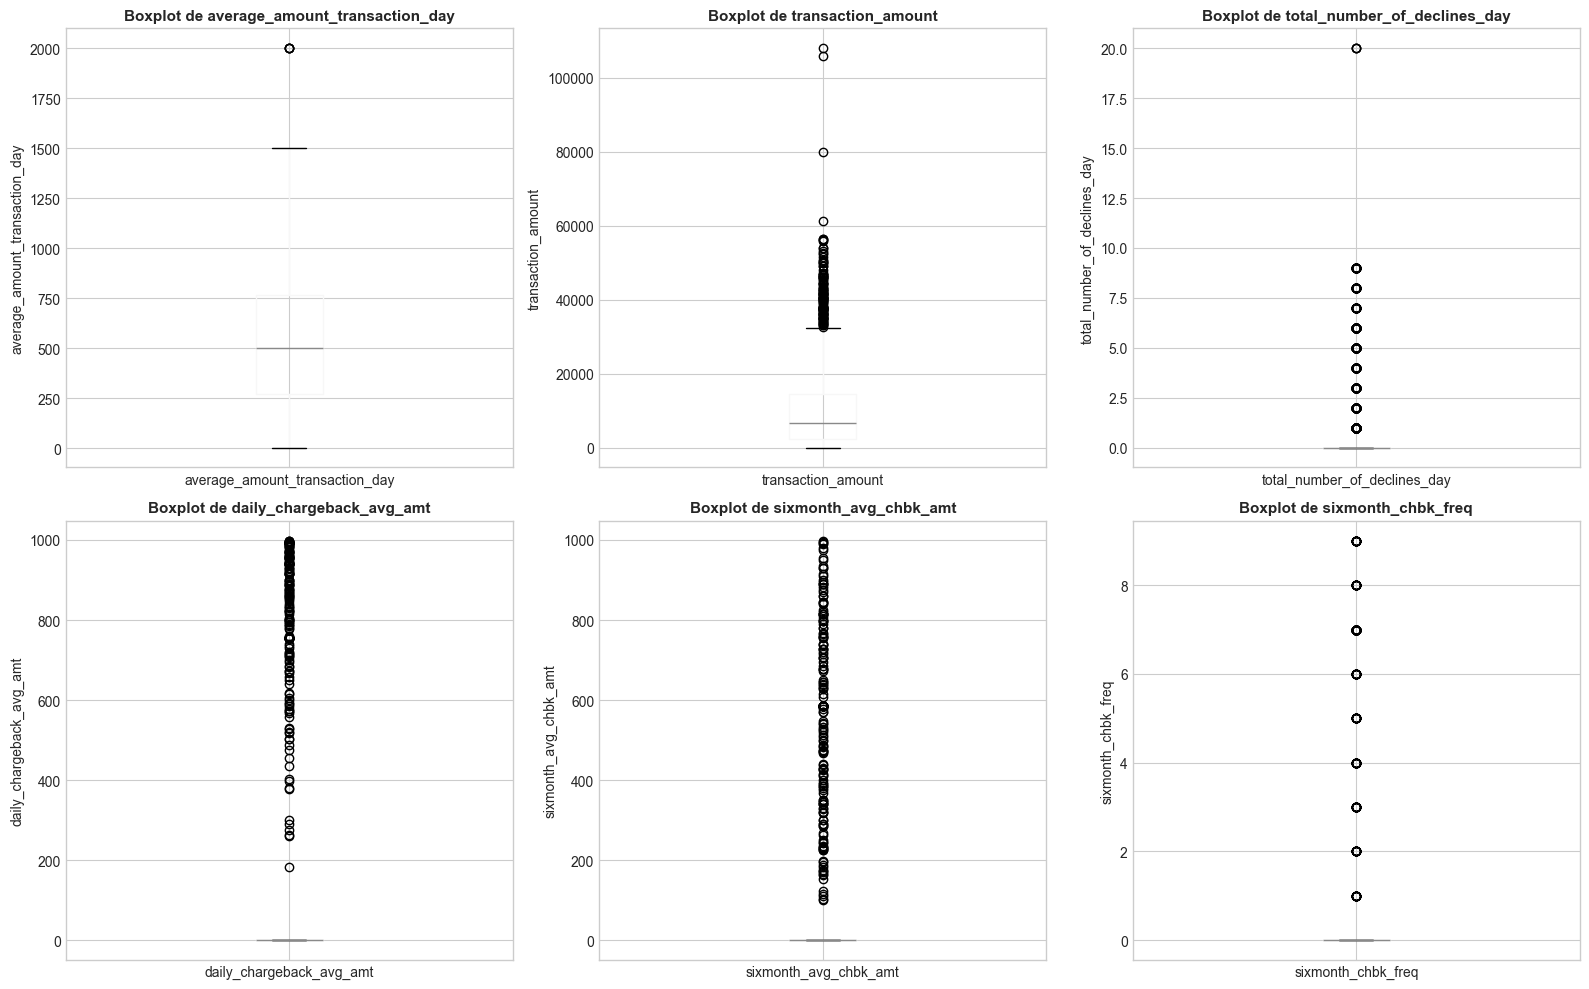

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    if col in df.columns:
        df.boxplot(column=col, ax=ax)
        ax.set_title(f'Boxplot de {col}', fontsize=11, fontweight='bold')
        ax.set_ylabel(col)

plt.tight_layout()
plt.show()

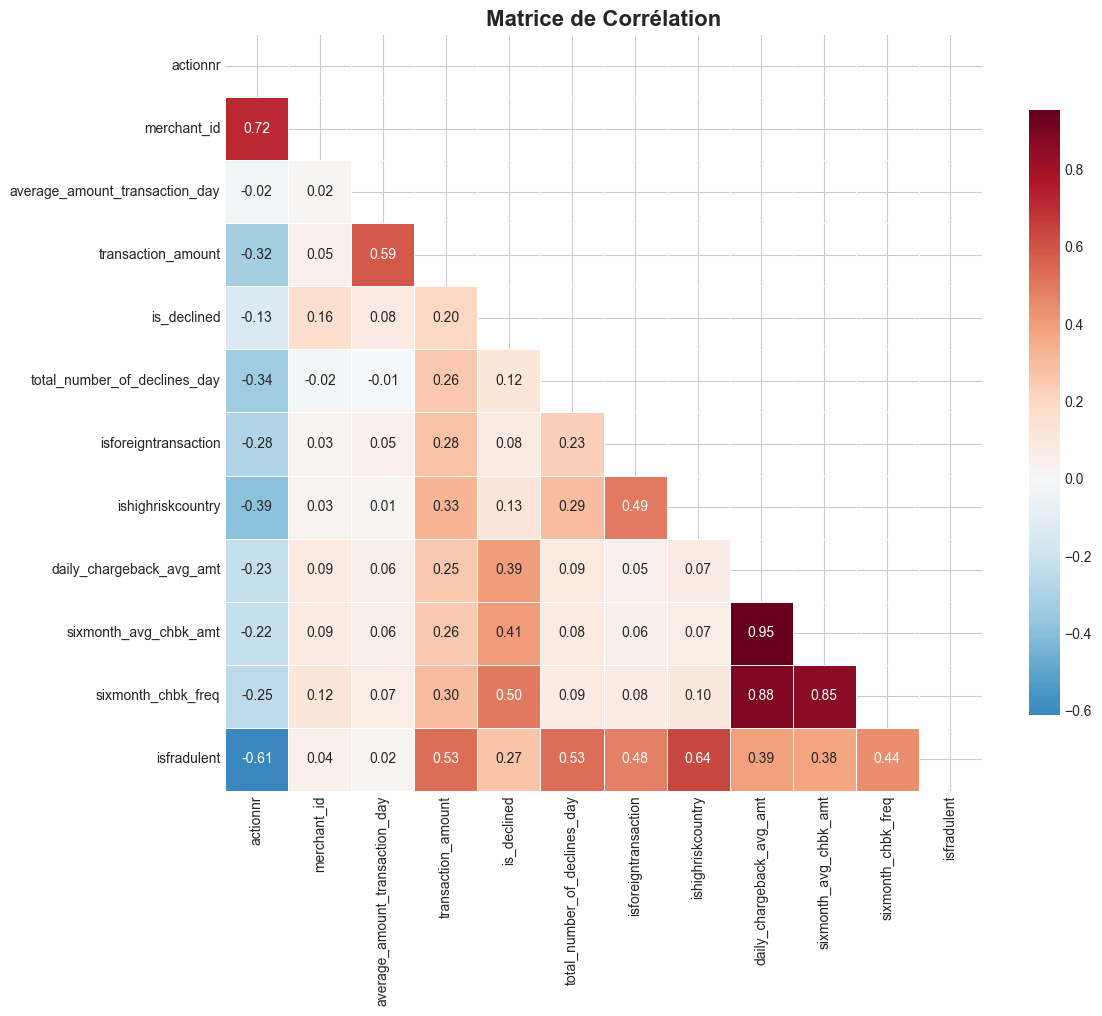

CORRÉLATION AVEC  isfradulent
isfradulent                       1.000000
ishighriskcountry                 0.639792
total_number_of_declines_day      0.531990
transaction_amount                0.528913
isforeigntransaction              0.478113
sixmonth_chbk_freq                0.443824
daily_chargeback_avg_amt          0.385964
sixmonth_avg_chbk_amt             0.375758
is_declined                       0.271282
merchant_id                       0.043068
average_amount_transaction_day    0.023643
actionnr                         -0.611061
Name: isfradulent, dtype: float64


In [56]:
df_corr = df.copy()

mapping = {'Y': 1, 'N': 0, 'y': 1, 'n': 0}
for col in ['is_declined', 'isforeigntransaction', 'ishighriskcountry', 'isfradulent']:
    if col in df_corr.columns:
        df_corr[col] = df_corr[col].map(mapping)

df_corr_numeric = df_corr.select_dtypes(include=[np.number])
correlation_matrix = df_corr_numeric.corr()

# Visualisation
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, linewidths=0.5,
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Matrice de Corrélation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


print("CORRÉLATION AVEC  isfradulent")
target_corr = correlation_matrix['isfradulent'].sort_values(ascending=False)
print(target_corr)

In [57]:
df_processed = df.copy()
cols_to_drop = ['actionnr', 'merchant_id']

for col in cols_to_drop:
    if col in df_processed.columns:
        df_processed.drop(col, axis=1, inplace=True)

In [58]:
print(df_processed.isnull().sum())
numeric_columns = df_processed.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    if df_processed[col].isnull().sum() > 0:
        median_value = df_processed[col].median()
        df_processed[col].fillna(median_value, inplace=True)

print(f"\n Valeurs manquantes après traitement: {df_processed.isnull().sum().sum()}")

average_amount_transaction_day    1
transaction_amount                0
is_declined                       0
total_number_of_declines_day      0
isforeigntransaction              0
ishighriskcountry                 0
daily_chargeback_avg_amt          0
sixmonth_avg_chbk_amt             0
sixmonth_chbk_freq                0
isfradulent                       0
dtype: int64

 Valeurs manquantes après traitement: 1


In [59]:
dub = df_processed.duplicated().sum()
print(f"Nombre de doublon : {dub}")

if dub > 0:
    df_processed = df_processed.drop_duplicates()

Nombre de doublon : 1


In [60]:
bool_columns = ['is_declined', 'isforeigntransaction', 'ishighriskcountry', 'isfradulent']
encoding_map = {'Y': 1, 'N': 0, 'y': 1, 'n': 0}

for col in bool_columns:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].map(encoding_map)

df_processed.head()

,average_amount_transaction_day,transaction_amount,is_declined,total_number_of_declines_day,isforeigntransaction,ishighriskcountry,daily_chargeback_avg_amt,sixmonth_avg_chbk_amt,sixmonth_chbk_freq,isfradulent
0,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,500.0,26000.0,0,0,1,1,800,677.2,6,1


In [61]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound))
    return outliers.sum(), lower_bound, upper_bound


numeric_cols_for_outliers = ['average_amount_transaction_day', 'transaction_amount', 
                             'total_number_of_declines_day', 'daily_chargeback_avg_amt',
                             'sixmonth_avg_chbk_amt', 'sixmonth_chbk_freq']

outliers_summary = []
for col in numeric_cols_for_outliers:
    if col in df_processed.columns:
        n_outliers, lower, upper = detect_outliers_iqr(df_processed, col)
        outliers_summary.append({
            'Colonne': col,
            'Outliers': n_outliers,
            'Pourcentage': f"{(n_outliers/len(df_processed))*100:.2f}%",
            'Borne_Inf': round(lower, 2),
            'Borne_Sup': round(upper, 2)
        })

outliers_df = pd.DataFrame(outliers_summary)
print(outliers_df.to_string(index=False))

                       Colonne  Outliers Pourcentage  Borne_Inf  Borne_Sup
average_amount_transaction_day         4       0.13%    -473.27    1508.16
            transaction_amount       113       3.68%  -15617.49   32452.56
  total_number_of_declines_day       691      22.48%       0.00       0.00
      daily_chargeback_avg_amt       218       7.09%       0.00       0.00
         sixmonth_avg_chbk_amt       218       7.09%       0.00       0.00
            sixmonth_chbk_freq       218       7.09%       0.00       0.00


In [62]:

def winsorize_column(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    return df[column].clip(lower=lower_bound, upper=upper_bound)

df_winsorized = df_processed.copy()

for col in numeric_cols_for_outliers:
    if col in df_winsorized.columns:
        df_winsorized[col] = winsorize_column(df_winsorized, col)

print("Winsorization appliquée (1er-99ème percentile)")
print("\nAvant:")
print(df_processed[numeric_cols_for_outliers].describe().round(2))
print("\nAprès:")
print(df_winsorized[numeric_cols_for_outliers].describe().round(2))

Winsorization appliquée (1er-99ème percentile)

Avant:
       average_amount_transaction_day  transaction_amount  \
count                         3073.00             3074.00   
mean                           514.98             9878.27   
std                            291.94            10136.45   
min                              4.01                0.00   
25%                            269.77             2408.78   
50%                            502.55             6704.70   
75%                            765.13            14426.29   
max                           2000.00           108000.00   

       total_number_of_declines_day  daily_chargeback_avg_amt  \
count                       3074.00                   3074.00   
mean                           0.96                     55.76   
std                            2.19                    206.67   
min                            0.00                      0.00   
25%                            0.00                      0.00   
50%  

In [63]:
df_features = df_processed.copy()

df_features['ratio_trans_avg'] = df_features['transaction_amount'] / (
    df_features['average_amount_transaction_day'].replace(0, 1) + 1)

df_features['is_high_transaction'] = (df_features['ratio_trans_avg'] > 10).astype(int)

df_features['risk_score'] = (
    df_features['isforeigntransaction'] + 
    df_features['ishighriskcountry'] + 
    df_features['is_declined'] +
    (df_features['total_number_of_declines_day'] > 0).astype(int)
)

df_features['has_chargeback_history'] = (
    (df_features['daily_chargeback_avg_amt'] > 0) | 
    (df_features['sixmonth_avg_chbk_amt'] > 0)
).astype(int)

df_features['chargeback_trend'] = df_features['sixmonth_avg_chbk_amt'] / (
    df_features['daily_chargeback_avg_amt'].replace(0, 1) + 1)

df_features['foreign_high_risk'] = (
    df_features['isforeigntransaction'] * df_features['ishighriskcountry']
)

df_features = df_features.replace([np.inf, -np.inf], 0)
df_features = df_features.fillna(0)

print("Nouvelles features créées:")
new_features = ['ratio_trans_avg', 'is_high_transaction', 'risk_score', 
                'has_chargeback_history', 'chargeback_trend', 'foreign_high_risk']
for feat in new_features:
    print(f"    {feat}")

print(f"\nNouveau shape: {df_features.shape}")
print(f"NaN restants: {df_features.isnull().sum().sum()}")
df_features.head()

Nouvelles features créées:
    ratio_trans_avg
    is_high_transaction
    risk_score
    has_chargeback_history
    chargeback_trend
    foreign_high_risk

Nouveau shape: (3074, 16)
NaN restants: 0


,average_amount_transaction_day,transaction_amount,is_declined,total_number_of_declines_day,isforeigntransaction,ishighriskcountry,daily_chargeback_avg_amt,sixmonth_avg_chbk_amt,sixmonth_chbk_freq,isfradulent,ratio_trans_avg,is_high_transaction,risk_score,has_chargeback_history,chargeback_trend,foreign_high_risk
0,100.0,3000.0,0,5,1,1,0,0.0,0,1,29.702970,1,3,0,0.000000,1
1,100.0,4300.0,0,5,1,1,0,0.0,0,1,42.574257,1,3,0,0.000000,1
2,185.5,4823.0,1,5,0,0,0,0.0,0,1,25.860590,1,2,0,0.000000,0
3,185.5,5008.5,1,8,0,0,0,0.0,0,1,26.855228,1,2,0,0.000000,0
4,500.0,26000.0,0,0,1,1,800,677.2,6,1,51.896208,1,2,1,0.845443,1


isfradulent                       1.000000
ratio_trans_avg                   0.727352
risk_score                        0.689591
ishighriskcountry                 0.639781
foreign_high_risk                 0.639781
total_number_of_declines_day      0.531963
transaction_amount                0.528879
isforeigntransaction              0.478076
sixmonth_chbk_freq                0.443806
has_chargeback_history            0.392327
daily_chargeback_avg_amt          0.385943
chargeback_trend                  0.385157
sixmonth_avg_chbk_amt             0.375738
is_high_transaction               0.278129
is_declined                       0.271272
average_amount_transaction_day    0.023804
Name: isfradulent, dtype: float64


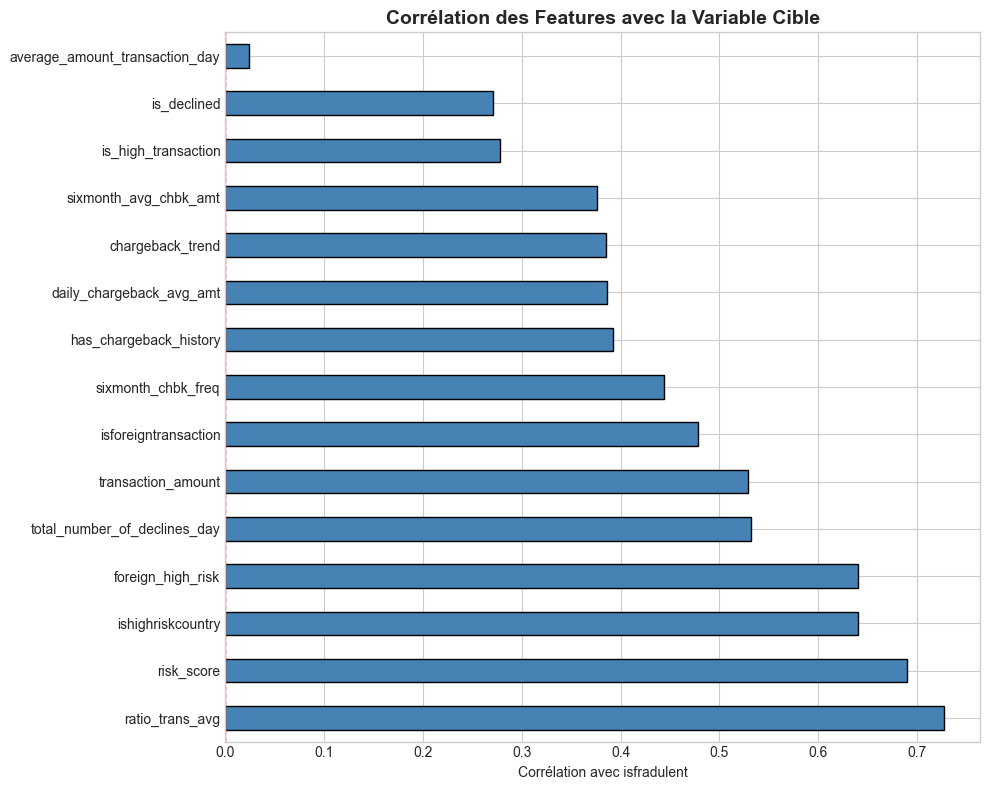

In [64]:
feature_correlations = df_features.corr()['isfradulent'].sort_values(ascending=False)

print(feature_correlations)

plt.figure(figsize=(10, 8))
feature_correlations.drop('isfradulent').plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Corrélation avec isfradulent')
plt.title('Corrélation des Features avec la Variable Cible', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

In [65]:
X = df_features.drop('isfradulent', axis=1)
y = df_features['isfradulent']

print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print(f"\n Liste des features ({len(X.columns)}):")
for col in X.columns:
    print(f" {col}")

 Features shape: (3074, 15)
 Target shape: (3074,)

 Liste des features (15):
 average_amount_transaction_day
 transaction_amount
 is_declined
 total_number_of_declines_day
 isforeigntransaction
 ishighriskcountry
 daily_chargeback_avg_amt
 sixmonth_avg_chbk_amt
 sixmonth_chbk_freq
 ratio_trans_avg
 is_high_transaction
 risk_score
 has_chargeback_history
 chargeback_trend
 foreign_high_risk


In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


print(f"Train : {len(X_train)} échantillons")
print(f"Test  : {len(X_test)} échantillons")

print("\nTrain :")
print(f"  normal : {(y_train == 0).sum()}")
print(f"  fraude     : {(y_train == 1).sum()}")

print("\nTest :")
print(f"  normal : {(y_test == 0).sum()}")
print(f"  fraude     : {(y_test == 1).sum()}")


Train : 2459 échantillons
Test  : 615 échantillons

Train :
  normal : 2101
  fraude     : 358

Test :
  normal : 525
  fraude     : 90


In [67]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("🔍 Vérification des NaN après normalisation:")
print(f"    NaN dans X_train_scaled: {X_train_scaled.isnull().sum().sum()}")
print(f"    NaN dans X_test_scaled: {X_test_scaled.isnull().sum().sum()}")

# remplacer les NaN et infinis par 0
X_train_scaled = X_train_scaled.replace([np.inf, -np.inf], 0)
X_train_scaled = X_train_scaled.fillna(0)
X_test_scaled = X_test_scaled.replace([np.inf, -np.inf], 0)
X_test_scaled = X_test_scaled.fillna(0)

print(X_train_scaled.describe().round(3))

🔍 Vérification des NaN après normalisation:
    NaN dans X_train_scaled: 0
    NaN dans X_test_scaled: 0
       average_amount_transaction_day  transaction_amount  is_declined  \
count                        2459.000            2459.000     2459.000   
mean                            0.028               0.259        0.019   
std                             0.589               0.826        0.136   
min                            -1.029              -0.563        0.000   
25%                            -0.462              -0.350        0.000   
50%                             0.000               0.000        0.000   
75%                             0.538               0.650        0.000   
max                             3.056               8.385        1.000   

       total_number_of_declines_day  isforeigntransaction  ishighriskcountry  \
count                      2459.000              2459.000           2459.000   
mean                          0.973                 0.231           

In [68]:
# ============================================
# NORMALISATION DES DONNÉES
# ============================================

# RobustScaler est recommandé quand il y a des outliers
# Il utilise la médiane et l'IQR au lieu de la moyenne et l'écart-type

scaler = RobustScaler()

# Fit sur les données d'entraînement uniquement!
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir en DataFrame pour garder les noms des colonnes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# ============================================
# GESTION DES NaN APRÈS NORMALISATION
# ============================================
print("🔍 Vérification des NaN après normalisation:")
print(f"   • NaN dans X_train_scaled: {X_train_scaled.isnull().sum().sum()}")
print(f"   • NaN dans X_test_scaled: {X_test_scaled.isnull().sum().sum()}")

# Remplacer les NaN et infinis par 0
X_train_scaled = X_train_scaled.replace([np.inf, -np.inf], 0)
X_train_scaled = X_train_scaled.fillna(0)
X_test_scaled = X_test_scaled.replace([np.inf, -np.inf], 0)
X_test_scaled = X_test_scaled.fillna(0)

print("✅ NaN et valeurs infinies traités!")

print("\n📊 Données normalisées avec RobustScaler")
print("\n📊 Statistiques après normalisation (Train):")
print(X_train_scaled.describe().round(3))

🔍 Vérification des NaN après normalisation:
   • NaN dans X_train_scaled: 0
   • NaN dans X_test_scaled: 0
✅ NaN et valeurs infinies traités!

📊 Données normalisées avec RobustScaler

📊 Statistiques après normalisation (Train):
       average_amount_transaction_day  transaction_amount  is_declined  \
count                        2459.000            2459.000     2459.000   
mean                            0.028               0.259        0.019   
std                             0.589               0.826        0.136   
min                            -1.029              -0.563        0.000   
25%                            -0.462              -0.350        0.000   
50%                             0.000               0.000        0.000   
75%                             0.538               0.650        0.000   
max                             3.056               8.385        1.000   

       total_number_of_declines_day  isforeigntransaction  ishighriskcountry  \
count                    

In [72]:

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek


smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n sans SMOTE: {len(y_train)} ")
print(f"    0: {(y_train == 0).sum()}")
print(f"    1: {(y_train == 1).sum()}")

print(f"\n avec SMOTE: {len(y_train_smote)} ")
print(f"    0: {(y_train_smote == 0).sum()}")
print(f"    1: {(y_train_smote == 1).sum()}")

    


 sans SMOTE: 2459 
    0: 2101
    1: 358

 avec SMOTE: 4202 
    0: 2101
    1: 2101


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, 
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, 
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        class_weight='balanced', 
        random_state=42
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5
    ),
    'Naive Bayes': GaussianNB()
}


 6


In [75]:
def evaluate_model(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }
    
    return metrics, y_pred, y_pred_proba

results = {}
predictions = {}


for name, model in models.items():
    print(f"\n Entrainement de {name}")
    metrics, y_pred, y_pred_proba = evaluate_model(
        model, X_train_scaled, y_train, X_test_scaled, y_test
    )
    results[name] = metrics
    predictions[name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
    print(f"   Terminé - F1-Score: {metrics['F1-Score']:.4f}")



 Entrainement de Logistic Regression
   Terminé - F1-Score: 0.9405

 Entrainement de Random Forest
   Terminé - F1-Score: 0.9560

 Entrainement de Gradient Boosting
   Terminé - F1-Score: 0.9721

 Entrainement de Decision Tree
   Terminé - F1-Score: 0.9189

 Entrainement de KNN
   Terminé - F1-Score: 0.8691

 Entrainement de Naive Bayes
   Terminé - F1-Score: 0.8737


In [77]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

results_df = results_df.sort_values('F1-Score', ascending=False)

print(results_df.to_string())

best_model_name = results_df['F1-Score'].idxmax()
print(f"\nthe best model (F1-Score): {best_model_name}")

                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Gradient Boosting      0.9919     0.9775  0.9667    0.9721   0.9967
Random Forest          0.9870     0.9457  0.9667    0.9560   0.9926
Logistic Regression    0.9821     0.9158  0.9667    0.9405   0.9981
Decision Tree          0.9756     0.8947  0.9444    0.9189   0.9627
Naive Bayes            0.9610     0.8300  0.9222    0.8737   0.9810
KNN                    0.9593     0.8218  0.9222    0.8691   0.9822

the best model (F1-Score): Gradient Boosting


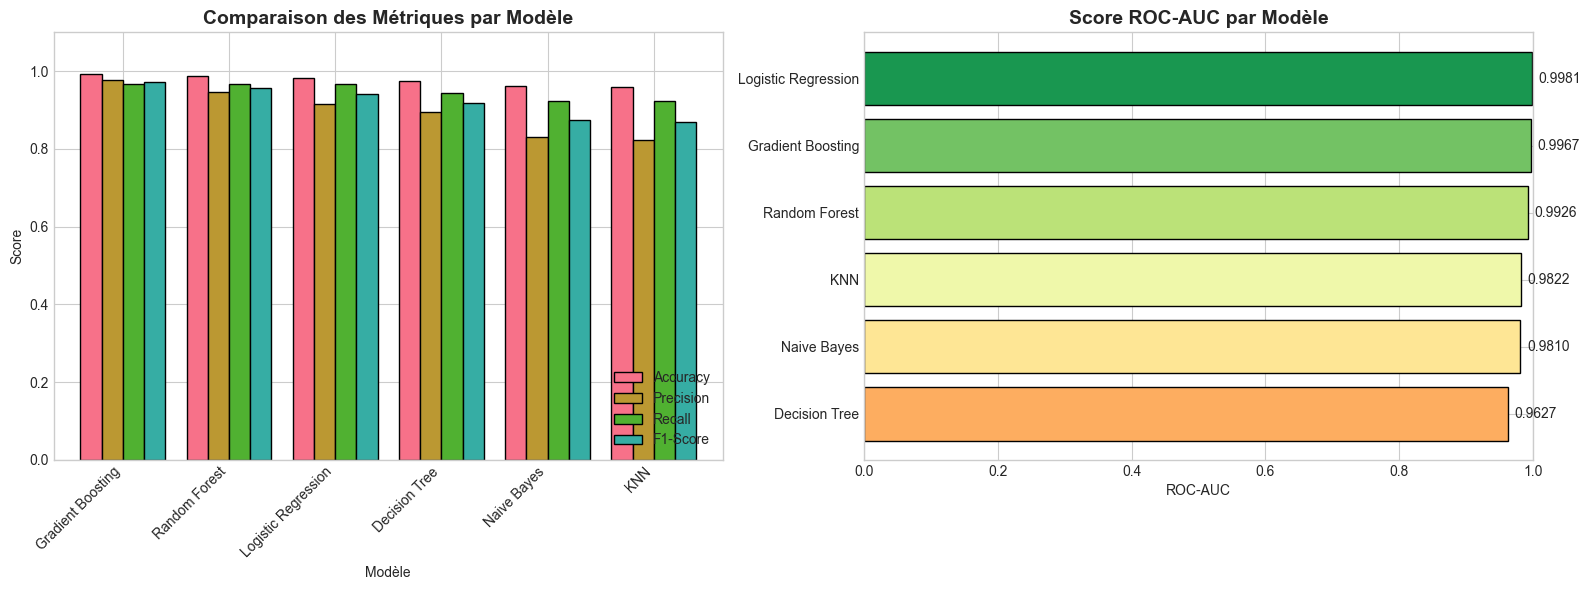

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', ax=ax1, width=0.8, edgecolor='black'
)
ax1.set_title('Comparaison des Métriques par Modèle', fontsize=14, fontweight='bold')
ax1.set_xlabel('Modèle')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1.1)
ax1.legend(loc='lower right')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Graphique 2: ROC-AUC
ax2 = axes[1]
roc_auc_scores = results_df['ROC-AUC'].dropna().sort_values(ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(roc_auc_scores)))
bars = ax2.barh(roc_auc_scores.index, roc_auc_scores.values, color=colors, edgecolor='black')
ax2.set_title('Score ROC-AUC par Modèle', fontsize=14, fontweight='bold')
ax2.set_xlabel('ROC-AUC')
ax2.set_xlim(0, 1)
for bar, score in zip(bars, roc_auc_scores.values):
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

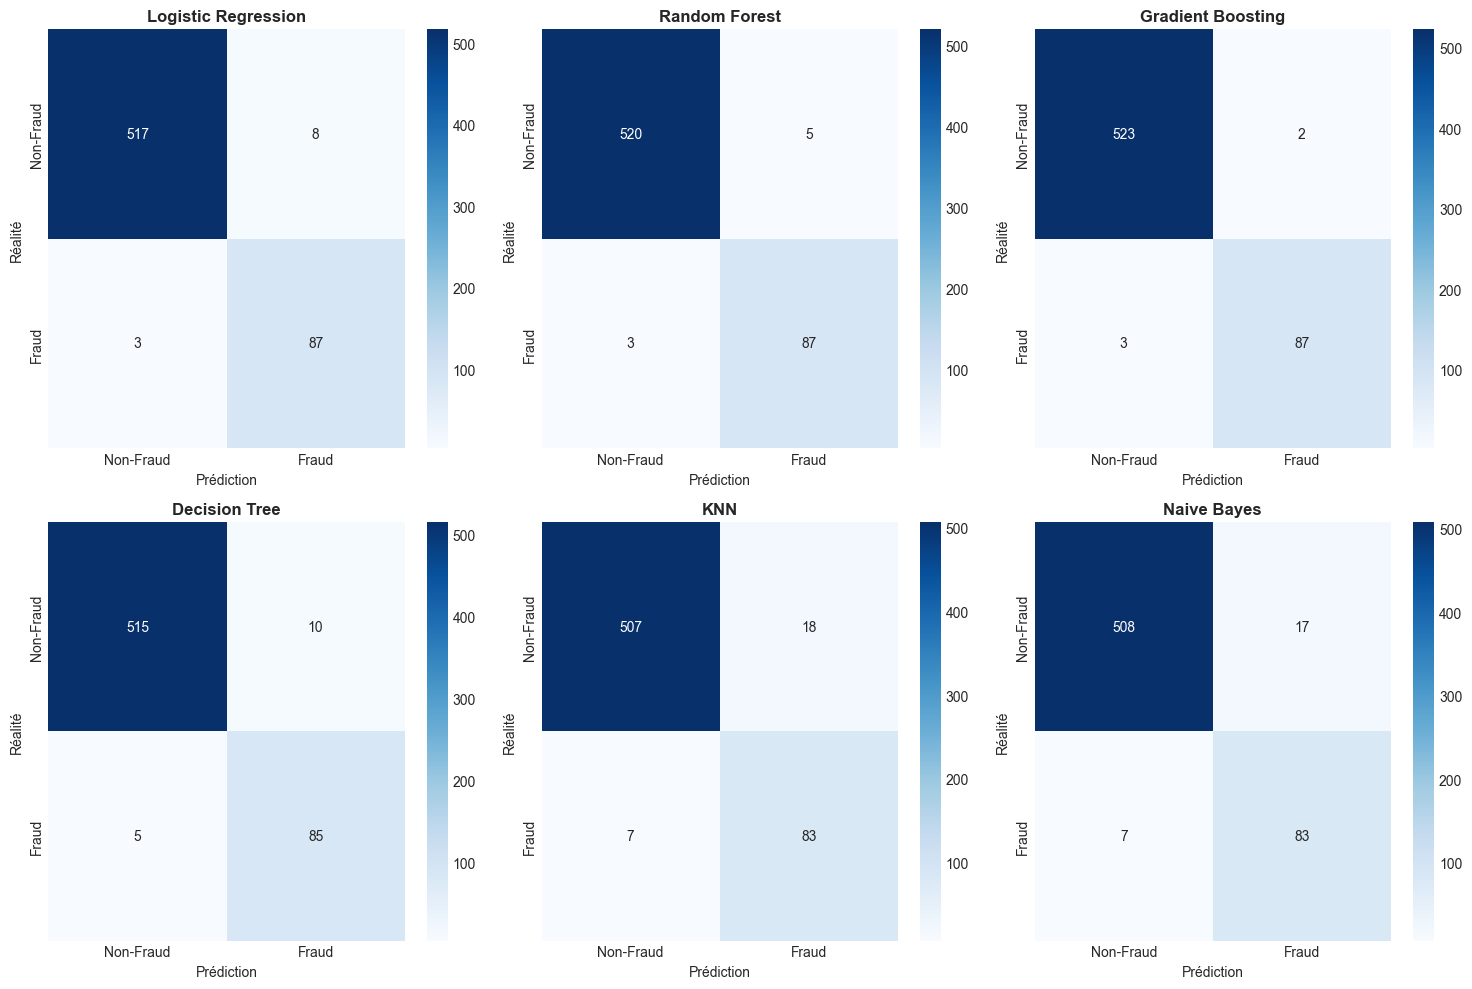

In [82]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, pred_data) in enumerate(predictions.items()):
    ax = axes[idx]
    cm = confusion_matrix(y_test, pred_data['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Prédiction')
    ax.set_ylabel('Réalité')

plt.tight_layout()
plt.show()

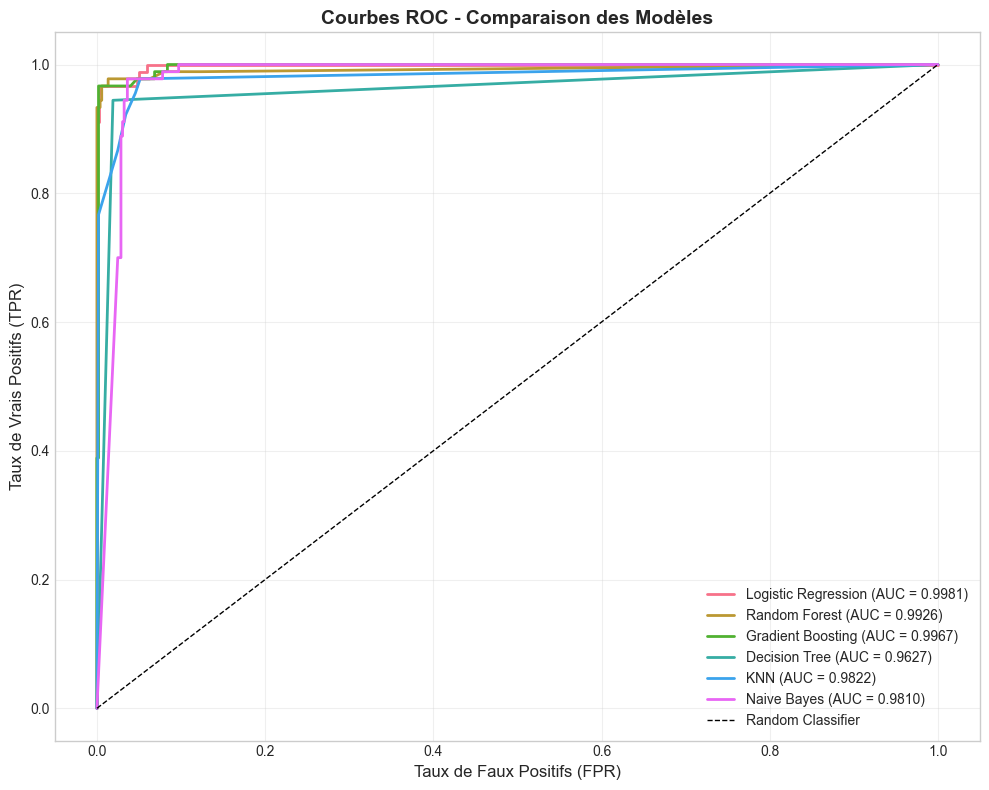

In [ ]:
plt.figure(figsize=(10, 8))

for name, pred_data in predictions.items():
    if pred_data['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, pred_data['y_pred_proba'])
        auc = roc_auc_score(y_test, pred_data['y_pred_proba'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

                       Feature  Importance
               ratio_trans_avg    0.364273
                    risk_score    0.151212
  total_number_of_declines_day    0.101216
          isforeigntransaction    0.062808
            transaction_amount    0.050044
             foreign_high_risk    0.049621
             ishighriskcountry    0.046170
            sixmonth_chbk_freq    0.036182
         sixmonth_avg_chbk_amt    0.033096
              chargeback_trend    0.025878
           is_high_transaction    0.024495
        has_chargeback_history    0.018874
      daily_chargeback_avg_amt    0.017048
average_amount_transaction_day    0.016860
                   is_declined    0.002222


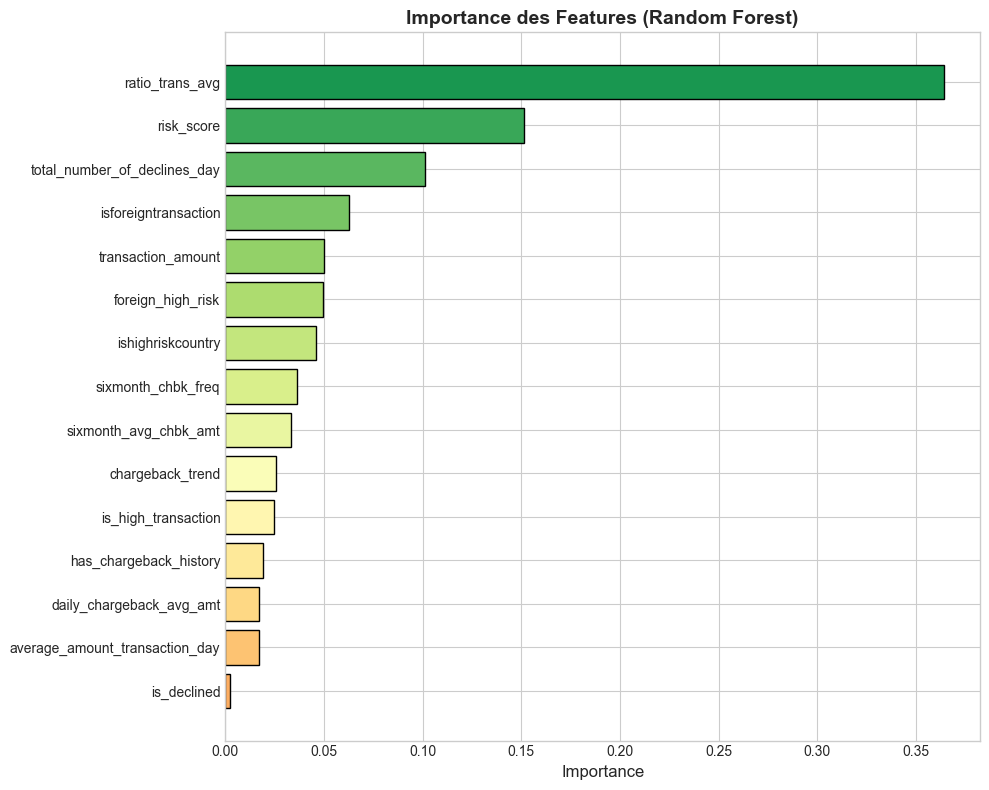

In [85]:
rf_model = models['Random Forest']
rf_model.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)


print(feature_importance.to_string(index=False))

plt.figure(figsize=(10, 8))
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(feature_importance)))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
                color=colors[::-1], edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.title('Importance des Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [87]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print(" Recherche des meilleurs hyperparamètres...")
grid_search.fit(X_train_scaled, y_train)

print(f"\n Meilleurs paramètres trouvés:")
for param, value in grid_search.best_params_.items():
    print(f"    {param}: {value}")

print(f"\n Meilleur score F1 (CV): {grid_search.best_score_:.4f}")

 Recherche des meilleurs hyperparamètres...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

 Meilleurs paramètres trouvés:
   • max_depth: 10
   • min_samples_leaf: 1
   • min_samples_split: 2
   • n_estimators: 100

 Meilleur score F1 (CV): 0.9818


In [89]:
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_best, target_names=['Non-Fraud', 'Fraud']))

print("\n Métriques finales:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")

              precision    recall  f1-score   support

   Non-Fraud       0.99      0.99      0.99       525
       Fraud       0.95      0.97      0.96        90

    accuracy                           0.99       615
   macro avg       0.97      0.98      0.97       615
weighted avg       0.99      0.99      0.99       615


 Métriques finales:
   Accuracy: 0.9870
   Precision: 0.9457
   Recall: 0.9667
   F1-Score: 0.9560
   ROC-AUC: 0.9980


In [90]:
import pickle

with open('best_model_fraud_detection.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler_fraud_detection.pkl', 'wb') as f:
    pickle.dump(scaler, f)

df_features.to_csv('credit_card_processed.csv', index=False)